<a href="https://colab.research.google.com/github/ojumoolatimi/buenos-aires-housing-ml/blob/main/price_prediction(location%2C_area_and_neighborhood).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import warnings
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import OneHotEncoder

from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline

warnings.simplefilter(action="ignore", category=FutureWarning)

In [11]:
def wrangle(filepath):
    df = pd.read_csv(filepath)

    mask_ba = df['place_with_parent_names'].str.contains('Capital Federal')
    mask_ba = df['property_type'] == 'apartment'
    mask_price = df['price_aprox_usd'] < 400000



    df = df[mask_ba & mask_ba & mask_price]

    low, high = df['surface_covered_in_m2'].quantile([0.1, 0.9])
    mask_surf = df['surface_covered_in_m2'].between(low, high)
    df = df[mask_surf]

    df[['lat', 'lon']] = df['lat-lon'].str.split(',', expand = True).astype('float')
    df.drop(columns = 'lat-lon', inplace = True)

    #
    df['neighborhood'] = df['place_with_parent_names'].str.split('|', expand = True)[3]
    df.drop(columns = 'place_with_parent_names', inplace = True)

    #columns missing

    df.drop(columns = ['floor', 'expenses'], inplace = True)

    #drop low and high cardinality

    df.drop(columns = ['operation', 'property_type', 'properati_url', 'currency' ], inplace = True)

    #drop leakage columns
    df.drop(columns = ['price', 'price_aprox_local_currency', 'price_per_m2', 'price_usd_per_m2', ], inplace = True)

    #drop columns with multicollinearity

    df.drop(columns = ['rooms', 'surface_total_in_m2'], inplace = True)


    return df


In [12]:
frame1 = wrangle('/content/drive/MyDrive/dataset/buenos-aires-real-estate-1.csv')
print(frame1.shape)
frame1.head()

(2848, 5)


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
4,129000.0,70.0,-34.584651,-58.454693,Chacarita
8,200000.0,48.0,NaN,NaN,Tigre
9,87000.0,42.0,-34.638979,-58.500115,Villa Luro
14,70000.0,55.0,-34.644585,-58.594040,Morón
16,95000.0,48.0,NaN,NaN,La Matanza


In [24]:
files = glob('/content/drive/MyDrive/dataset/buenos-aires-real-estate-*.csv')
files

['/content/drive/MyDrive/dataset/buenos-aires-real-estate-3.csv',
 '/content/drive/MyDrive/dataset/buenos-aires-real-estate-4.csv',
 '/content/drive/MyDrive/dataset/buenos-aires-real-estate-1.csv',
 '/content/drive/MyDrive/dataset/buenos-aires-real-estate-2.csv',
 '/content/drive/MyDrive/dataset/buenos-aires-real-estate-5.csv']

In [25]:
frames = [wrangle (file) for file in files]
frames[0]

,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
2,175000.00,92.0,-34.703368,-58.392392,Lanús
4,90000.00,70.0,NaN,NaN,Ituzaingó
6,85000.00,68.0,-34.650200,-58.792369,Moreno
7,120000.00,55.0,-34.616004,-58.470506,Villa General Mitre
18,62481.09,45.0,-34.906980,-57.972214,La Plata
...,...,...,...,...,...
8595,98000.00,75.0,NaN,NaN,La Matanza
8596,85000.00,92.0,-34.706411,-58.382807,Lanús
8601,69058.04,51.0,-34.423544,-58.590317,Tigre
8602,120000.00,61.0,-34.600486,-58.533651,Tres de Febrero


In [26]:
df = pd.concat(frames, ignore_index = True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14239 entries, 0 to 14238
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        14239 non-null  float64
 1   surface_covered_in_m2  14239 non-null  float64
 2   lat                    11924 non-null  float64
 3   lon                    11924 non-null  float64
 4   neighborhood           14239 non-null  object 
dtypes: float64(4), object(1)
memory usage: 556.3+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,175000.00,92.0,-34.703368,-58.392392,Lanús
1,90000.00,70.0,NaN,NaN,Ituzaingó
2,85000.00,68.0,-34.650200,-58.792369,Moreno
3,120000.00,55.0,-34.616004,-58.470506,Villa General Mitre
4,62481.09,45.0,-34.906980,-57.972214,La Plata


In [27]:
df.isna().sum()/len(df)*100

,0
price_aprox_usd,0.000000
surface_covered_in_m2,0.000000
lat,16.258164
lon,16.258164
neighborhood,0.000000


In [28]:
df.nunique()

,0
price_aprox_usd,2149
surface_covered_in_m2,67
lat,7899
lon,7895
neighborhood,85


In [29]:
sorted(df.columns.to_list())

['lat', 'lon', 'neighborhood', 'price_aprox_usd', 'surface_covered_in_m2']

<Axes: >

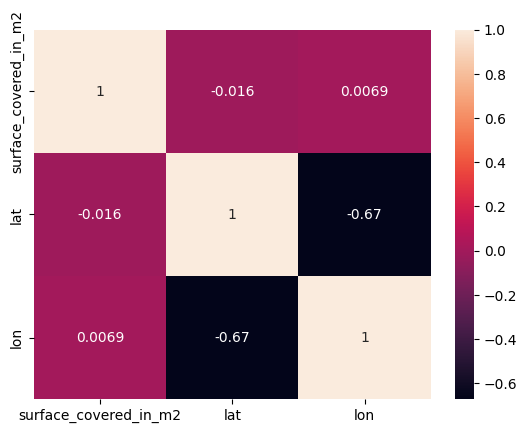

In [30]:
corr = df.select_dtypes('number').drop(columns = 'price_aprox_usd').corr()
sns.heatmap(corr, annot = True)

split

In [31]:
features = ['surface_covered_in_m2', 'lat', 'lon', 'neighborhood' ]
X_train = df[features]
X_train

,surface_covered_in_m2,lat,lon,neighborhood
0,92.0,-34.703368,-58.392392,Lanús
1,70.0,NaN,NaN,Ituzaingó
2,68.0,-34.650200,-58.792369,Moreno
3,55.0,-34.616004,-58.470506,Villa General Mitre
4,45.0,-34.906980,-57.972214,La Plata
...,...,...,...,...
14234,81.0,-34.415562,-58.579895,Tigre
14235,57.0,-34.479104,-58.757840,Malvinas Argentinas
14236,46.0,-34.620384,-58.387360,Monserrat
14237,66.0,NaN,NaN,La Matanza


In [32]:
target = 'price_aprox_usd'
y_train = df[target]
y_train

,price_aprox_usd
0,175000.00
1,90000.00
2,85000.00
3,120000.00
4,62481.09
...,...
14234,147750.00
14235,69000.00
14236,89000.00
14237,100000.00


In [33]:
print(X_train.shape)
print(y_train.shape)

(14239, 4)
(14239,)


baseline model

In [34]:
y_mean = y_train.mean()
print('y_train_mean:', y_mean.round(2))

y_train_mean: 127228.07


In [35]:
y_pred_baseline = [y_mean]*len(y_train)
y_pred_baseline[:5]

[np.float64(127228.07365896481),
 np.float64(127228.07365896481),
 np.float64(127228.07365896481),
 np.float64(127228.07365896481),
 np.float64(127228.07365896481)]

In [36]:
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print('y_train_mean:', y_mean.round(2))
print('mae_baseline', round(mae_baseline, 2))

y_train_mean: 127228.07
mae_baseline 46931.13


model training

In [37]:
model = make_pipeline(OneHotEncoder(), SimpleImputer(), Ridge())
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=['neighborhood'])),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

Evaluation

In [38]:
y_pred_training = model.predict(X_train)
y_pred_training[:5]

array([169621.67981482, 127756.64202817, 116849.2269022 , 120716.0400761 ,
        64692.77129461])

In [39]:
MAE_training = mean_absolute_error(y_train, y_pred_training)
print('MAE_training:', round(MAE_training, 2))

MAE_training: 26587.4


In [40]:
result_df = pd.DataFrame({'actual': y_train[:10], 'predicted' : y_pred_training[:10]})
display(result_df)

,actual,predicted
0,175000.00,169621.679815
1,90000.00,127756.642028
2,85000.00,116849.226902
3,120000.00,120716.040076
4,62481.09,64692.771295
5,89000.00,130342.867903
6,183495.00,139862.834038
7,165000.00,129005.475718
8,124000.00,100318.073047
9,70000.00,85168.213808


Result Communication

In [41]:
def make_prediction(area, lat, lon, neighborhood):
     data = {'surface_covered_in_m2': area,
     'lat': lat,
     'lon': lon,
     'neighborhood': neighborhood}
     df = pd.DataFrame(data, index = [0])
     prediction = model.predict(df).round(2)

     return f"Predicted apartment price: ${prediction}"


In [42]:
make_prediction(80, -60.51,	-45.93, 'Tigre'	)

'Predicted apartment price: $[200747.51]'

interactive dashboard, where a user can supply values and receive a prediction.

In [43]:
interact(make_prediction,
         area = IntSlider(
             min = X_train['surface_covered_in_m2'].min(),
             max = X_train['surface_covered_in_m2'].max(),
             value = X_train['surface_covered_in_m2'].mean()),
         lat = FloatSlider(
             min = X_train['lat'].min(),
             max = X_train['lat'].max(),
             step = 0.01,
             value = X_train['lat'].mean()),
         lon = FloatSlider(
             min = X_train['lon'].min(),
             max = X_train['lon'].max(),
             step = 0.01,
             value = X_train['lon'].mean()),
         neighborhood = Dropdown(options = sorted(X_train['neighborhood'].unique())))


interactive(children=(IntSlider(value=54, description='area', max=98, min=32), FloatSlider(value=-34.483954795…

<function __main__.make_prediction(area, lat, lon, neighborhood)>